In [20]:
import wandb
import warnings
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from dice_ml.explainer_interfaces.explainer_base import UserConfigValidationException
from datetime import timedelta
import os
import re
import joblib
import sys
from aeon.utils.numba.stats import row_mean
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sympy import false

from scripts.SEP_CFE_functions import *
from slim_tsf.func.BaseSLIM import *
from slim_tsf.func._slim_TSF import *
from slim_tsf.func._sliding_intervals import *
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from slim_tsf.func._slim_TSF import SlimTimeSeriesForestClassifier

In [21]:
#load data from file
data = np.load("/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/processed/sep_slim_tsf_input_dataset.npz")
X = data['X']
y = data['y']

In [22]:
temp_x, test_x, temp_y, test_y = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
train_x, val_x, train_y, val_y = train_test_split(temp_x, temp_y, test_size=0.3, stratify=temp_y, random_state=42)

print(f"Train size: {train_x.shape[0]}, Val size: {val_x.shape[0]}, Test size: {test_x.shape[0]}")

Train size: 1416, Val size: 608, Test size: 868


In [23]:
clf_ref = SlimTimeSeriesForestClassifier(
    sec_trans=False,
    bootstrap=False,
    n_estimators=300,
    max_dep=5,
    random_state=42,
    windows=[360, 180, 120, 90, 60, 45, 30, 15, 6],
    windows_steps_ratio=0.25,
    features=[row_mean]
)


In [24]:
clf_short = SlimTimeSeriesForestClassifier(
    sec_trans=False,
    bootstrap=False,
    n_estimators=300,
    max_dep=5,
    random_state=42,
    windows=[60, 45, 30, 15, 6],
    windows_steps_ratio=0.1,   # finer stride → more intervals
    features=[row_mean]
)


In [25]:
clf_long = SlimTimeSeriesForestClassifier(
    sec_trans=False,
    bootstrap=False,
    n_estimators=300,
    max_dep=6,
    random_state=42,
    windows=[360, 240, 180],
    windows_steps_ratio=0.5,
    features=[row_mean]
)


In [26]:
clf_multi = SlimTimeSeriesForestClassifier(
    sec_trans=False,
    bootstrap=False,
    n_estimators=400,
    max_dep=6,
    random_state=42,
    windows=[360, 240, 180, 120, 90, 60, 45, 30, 15, 6],
    windows_steps_ratio=0.2,
    features=[row_mean]
)


In [27]:
clf_boot = SlimTimeSeriesForestClassifier(
    sec_trans=False,
    bootstrap=True,        # enable bootstrap
    bootstrap_run=20,      # more iterations for stable ranking
    top_rank=40,
    n_estimators=300,
    max_dep=5,
    random_state=42,
    windows=[180, 120, 90, 45, 30, 15],
    windows_steps_ratio=0.25,
    features=[row_mean]
)


In [28]:
models = {
    "reference": clf_ref,
    "short_term": clf_short,
    "long_term": clf_long,
    "multi_scale": clf_multi,
    "bootstrap": clf_boot
}

topk_results = {}

for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(train_x, train_y)
    importances = model.clf.feature_importances_
    intervals = model.tnf.intervals_
    ranked = sorted(
        [
            (imp, interval)
            for imp, interval in zip(importances, intervals)
            if callable(interval[3]) and getattr(interval[3], "__name__", "") == "row_mean"
        ],
        key=lambda x: x[0],
        reverse=True
    )
    topk_results[name] = ranked[:20]
    print(f"Top-K intervals extracted: {len(topk_results[name])}")



Training reference ...
Top-K intervals extracted: 20

Training short_term ...
Top-K intervals extracted: 20

Training long_term ...
Top-K intervals extracted: 20

Training multi_scale ...
Top-K intervals extracted: 20

Training bootstrap ...
Top-K intervals extracted: 2


Channel specific importance heatmaps

In [32]:
import numpy as np
import pandas as pd

# channel names (same order as in dataset)
channel_labels = ["P3", "P5", "P7", "Long"]

# convert each model’s top-k list into a time importance matrix
n_time = train_x.shape[2]
heatmaps = {}

for name, ranked in topk_results.items():
    mat = np.zeros((len(channel_labels), n_time))
    for imp, (start, end, ch, func, *_) in ranked:
        if getattr(func, "__name__", "") == "row_mean":
            mat[ch, start:end] += imp  # accumulate importance
    # normalize each channel
    mat = mat / (mat.max(axis=1, keepdims=True) + 1e-9)
    heatmaps[name] = mat


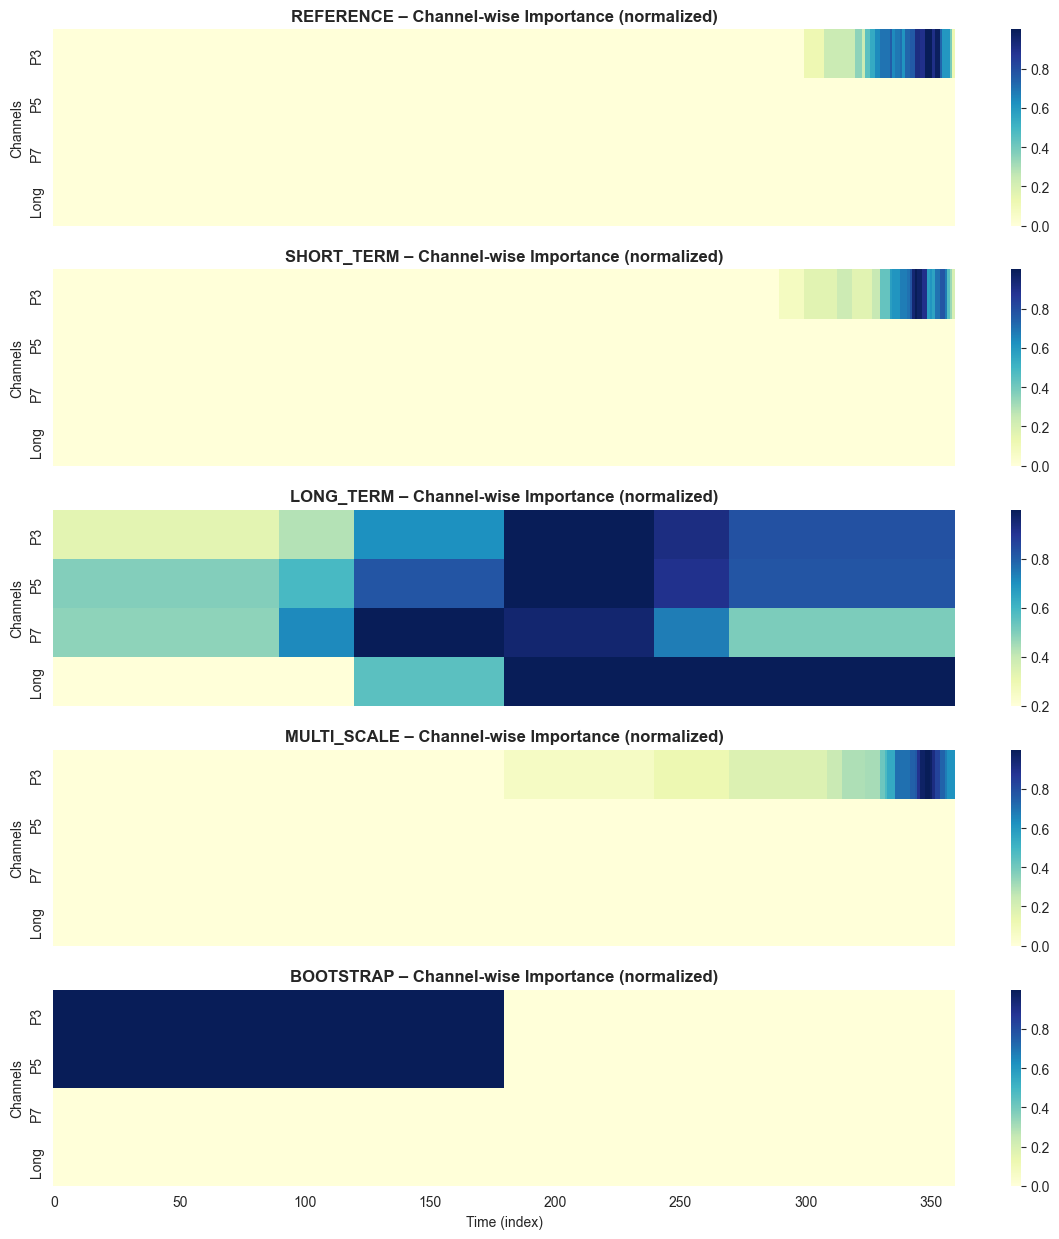

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(len(heatmaps), 1, figsize=(12, 2.5 * len(heatmaps)), sharex=True)

for ax, (name, mat) in zip(axes, heatmaps.items()):
    sns.heatmap(
        mat,
        cmap="YlGnBu",
        cbar=True,
        ax=ax,
        xticklabels=50,  # adjust tick frequency for clarity
        yticklabels=channel_labels
    )
    ax.set_title(f"{name.upper()} – Channel-wise Importance (normalized)", fontsize=12, weight="bold")
    ax.set_ylabel("Channels")

plt.xlabel("Time (index)")
plt.tight_layout()
plt.show()


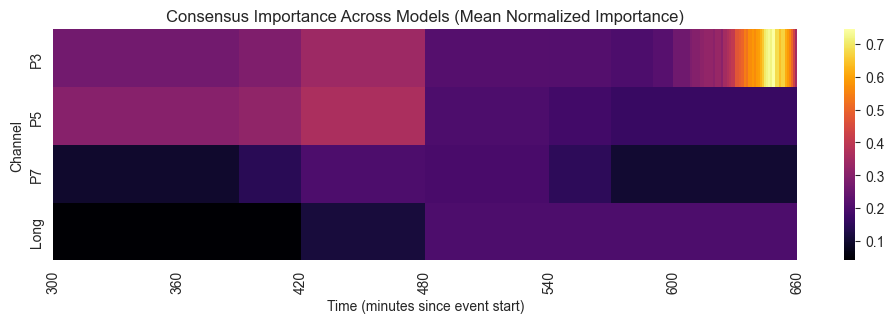

In [35]:
# combine all normalized maps
combined = np.mean(list(heatmaps.values()), axis=0)

start_min=300
end_min=660
plt.figure(figsize=(12, 3))
sns.heatmap(combined, cmap="inferno", yticklabels=channel_labels)
plt.title("Consensus Importance Across Models (Mean Normalized Importance)")
xticks = np.linspace(0, n_time, 7, dtype=int)
xticklabels = [f"{int(start_min + (x / n_time) * (end_min - start_min))}" for x in xticks]
plt.xticks(xticks, xticklabels)
plt.xlabel("Time (minutes since event start)")
plt.ylabel("Channel")
plt.show()


In [37]:
import numpy as np
from collections import Counter, defaultdict

def compute_interval_frequency(topk_results, n_time, channel_labels, func_filter="row_mean", top_k=20):
    """
    Compute how frequently each interval (or time range) produces a top feature
    across all models.

    Parameters
    ----------
    topk_results : dict
        Dict of {model_name: [(importance, (start, end, ch, func, ...)), ...]}
    n_time : int
        Number of timepoints per series (e.g. 360)
    channel_labels : list[str]
        Channel names in same order as dataset.
    func_filter : str, default='row_mean'
        Only count features using this function type (e.g. 'row_mean').
    top_k : int, default=20
        Only consider top K features from each model.

    Returns
    -------
    freq_mat : np.ndarray
        (n_channels, n_time) matrix with frequency scores.
    """

    freq_mat = np.zeros((len(channel_labels), n_time))
    interval_counter = defaultdict(int)

    for model_name, ranked in topk_results.items():
        for imp, (start, end, ch, func, *_) in ranked[:top_k]:
            # filter by feature type
            if getattr(func, "__name__", "") != func_filter:
                continue

            # increment frequency for all time indices covered by this interval
            freq_mat[ch, start:end] += 1
            # or store a tuple-based counter
            interval_counter[(start, end, ch)] += 1

    # normalize counts per channel (optional)
    freq_mat = freq_mat / freq_mat.max(axis=1, keepdims=True)

    print(f"Unique intervals seen: {len(interval_counter)}")
    return freq_mat, interval_counter


Unique intervals seen: 66


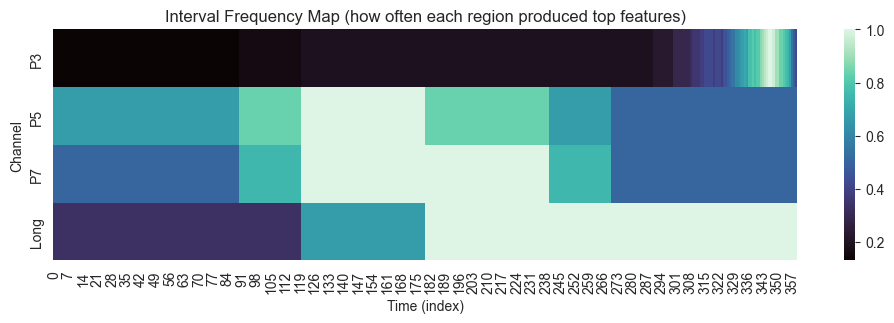

In [39]:
freq_mat, interval_counter = compute_interval_frequency(
    topk_results=topk_results,
    n_time=train_x.shape[2],
    channel_labels=["P3", "P5", "P7", "Long"],
    func_filter="row_mean",
    top_k=20
)

plt.figure(figsize=(12, 3))
sns.heatmap(freq_mat, cmap="mako", yticklabels=["P3", "P5", "P7", "Long"])
plt.title("Interval Frequency Map (how often each region produced top features)")
plt.xlabel("Time (index)")
plt.ylabel("Channel")
plt.show()


In [40]:
# Sort the most frequent intervals directly
sorted_intervals = sorted(interval_counter.items(), key=lambda x: x[1], reverse=True)
for (start, end, ch), count in sorted_intervals[:10]:
    print(f"{channel_labels[ch]} | [{start}:{end}] | occurred {count} times")


P3 | [348:354] | occurred 2 times
P3 | [352:358] | occurred 2 times
P3 | [342:348] | occurred 2 times
P3 | [346:352] | occurred 2 times
P3 | [336:342] | occurred 2 times
P3 | [338:344] | occurred 2 times
P3 | [336:351] | occurred 2 times
P3 | [332:338] | occurred 2 times
P3 | [330:360] | occurred 2 times
P3 | [350:356] | occurred 2 times


In [45]:
freq_mat

array([[0.12903226, 0.12903226, 0.12903226, ..., 0.5483871 , 0.48387097,
        0.41935484],
       [0.66666667, 0.66666667, 0.66666667, ..., 0.5       , 0.5       ,
        0.5       ],
       [0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.33333333, 0.33333333, 0.33333333, ..., 1.        , 1.        ,
        1.        ]])

Channel independent interval importance plots

In [43]:
global_freq = freq_mat.sum(axis=0)
# global_freq /= global_freq.max()  # normalize to [0,1]


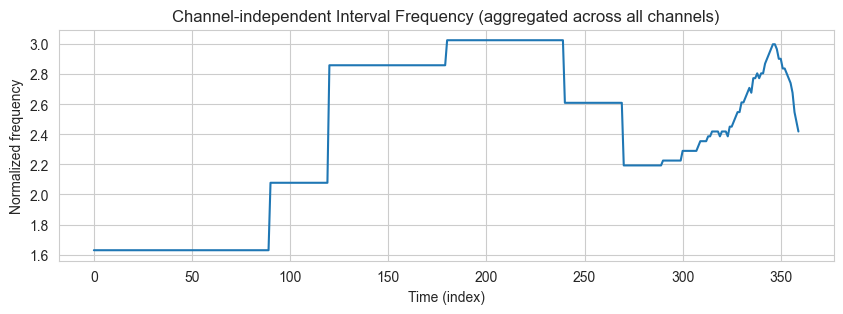

In [44]:
plt.figure(figsize=(10,3))
plt.plot(global_freq)
plt.title("Channel-independent Interval Frequency (aggregated across all channels)")
plt.xlabel("Time (index)")
plt.ylabel("Frequency")
plt.show()
